Profit function (Paquette Loss):  
$$\Pi:= \sum_{\textit{weeks with output } 1} 1\cdot(Close-Open)+\sum_{\textit{weeks with output } -1} -1\cdot(Close-Open)= \sum_{\textit{all weeks}} Output_{week}\cdot(Close-Open)$$

In [19]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader

import sys
sys.path.append(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\anfis_libraries')

import anfis
from membership import make_gauss_mfs, make_anfis
import experimental
import matplotlib.pyplot as plt

In [26]:
#msft = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Microsoft_weekly_ok.csv')
amzn = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Amazon_weekly_ok.csv')
#ibm = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\IBM_weekly_ok.csv')
#cac = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Cac_weekly_ok.csv')
#sp500 = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Sp500_weekly_ok.csv')
#nasdaq = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Nasdaq_weekly_ok.csv')

In [3]:
# Function to add indicators
def calculate_indicators(df):

    # 10 week and 40 week MA -> Corresponds to 50 vs 200 day MA
    df['MA10'] = df['Close'].rolling(window = 10).mean()
    df['MA40'] = df['Close'].rolling(window = 40).mean()

    # Calculate RSI

    delta = df['Close'].diff()
    up, down = delta.clip(lower = 0), -delta.clip(upper=0)
    ma_up = up.rolling(window = 14).mean()
    ma_down = down.rolling(window = 14).mean()

    RSI = 100 - (100 / (1 + ma_up / ma_down))
    df['RSI'] = RSI

    # Calculate MACD and Signal line
    df['EMA_12'] = df['Close'].ewm(span = 12, adjust = False).mean()
    df['EMA_26'] = df['Close'].ewm(span = 26, adjust = False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_line'] = df['MACD'].ewm(span = 9, adjust = False).mean()

    #Stochastic Oscillator
    df['14_high'] = df['High'].rolling(window = 14).max()
    df['14_low'] = df['Low'].rolling(window = 14).min()
    df['%K'] = (df['Close'] - df['14_low']) * 100 / (df['14_high'] - df['14_low'])
    df['%D'] = df['%K'].rolling(window = 3).mean()

    # Bollinger Bands
    df['MA_20'] = df['Close'].rolling(window = 20).mean()
    df['STD_20'] = df['Close'].rolling(window = 20).std()
    df['upper_band'] = df['MA_20'] + (df['STD_20'] * 2)
    df['lower_band'] = df['MA_20'] - (df['STD_20'] * 2)

    return df

In [16]:
# List of DataFrames
#dfs = [amzn, cac, ibm, msft, nasdaq, sp500]
dfs=[amzn]

# Apply the function
for df in dfs:
    calculate_indicators(df)

    # Also use loop to change date from object to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Ensure dates are sorted
    df.sort_values('Date', inplace=True)

amzn.drop(index=amzn.index[0:40], inplace=True)
amzn.reset_index()

,index,Date,Open,High,Low,Close,Volume,MA10,MA40,RSI,...,MACD,Signal_line,14_high,14_low,%K,%D,MA_20,STD_20,upper_band,lower_band
0,120,1999-09-05,127.5625,130.0000,57.3750,62.4375,69923100,57.78128,62.518252,52.225256,...,-1.245090,-0.759845,142.50,57.375,5.947137,-21.726271,62.240655,13.471858,89.184371,35.296939
1,121,1999-09-12,63.8125,68.0000,60.9375,66.5000,37592500,58.22815,63.395335,59.067819,...,-0.532656,-0.714407,142.50,57.375,10.719530,-4.224059,60.312530,9.056567,78.425663,42.199397
2,122,1999-09-19,65.6250,67.9375,62.5000,63.8125,38646100,58.33440,64.061480,57.892337,...,-0.182798,-0.608085,142.50,57.375,7.562408,8.076358,59.201590,6.823016,72.847622,45.555558
3,123,1999-09-26,63.6875,68.7500,60.6875,65.0000,49636300,57.95315,64.491948,56.918072,...,0.188120,-0.448844,142.50,57.375,8.957416,9.079785,59.042215,6.636757,72.315730,45.768700
4,124,1999-10-03,66.1875,85.0000,61.1250,77.2500,151004700,59.95002,65.069812,63.984216,...,1.453789,-0.068318,142.50,57.375,23.348018,13.289280,59.595340,7.647613,74.890567,44.300113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,1394,2024-02-04,159.3400,172.5000,154.8100,171.8100,334522911,153.59100,136.247375,86.463677,...,5.622299,2.443274,172.50,128.560,98.429677,96.646452,143.844500,12.722767,169.290034,118.398966
1275,1395,2024-02-11,170.2000,175.0000,167.6500,174.4500,244063321,156.33300,137.967250,84.332503,...,6.931692,3.340958,175.00,138.360,98.498908,97.717443,146.111000,13.940952,173.992904,118.229096
1276,1396,2024-02-18,174.8000,175.3900,165.7500,169.5100,248174038,158.54200,139.448500,74.861084,...,7.484503,4.169667,175.39,139.520,83.607471,93.512019,148.230500,14.122886,176.476271,119.984729
1277,1397,2024-02-25,167.8300,175.7500,165.7400,174.9900,201663539,161.04400,140.917000,76.592328,...,8.269474,4.989628,175.75,141.500,97.781022,93.295801,150.582000,14.480929,179.543858,121.620142


In [17]:
amzn.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'MA10', 'MA40', 'RSI',
       'EMA_12', 'EMA_26', 'MACD', 'Signal_line', '14_high', '14_low', '%K',
       '%D', 'MA_20', 'STD_20', 'upper_band', 'lower_band'],
      dtype='object')

In [22]:
amzn['MA40_MA10_difference_normalised']=(amzn['MA10']-amzn['MA40'])/amzn['MA40']
amzn['MA40_MA10_difference_normalised']

120    -0.075769
121    -0.081507
122    -0.089400
123    -0.101389
124    -0.078682
          ...   
1394    0.127295
1395    0.133117
1396    0.136922
1397    0.142829
1398    0.146838
Name: MA40_MA10_difference_normalised, Length: 1279, dtype: float64

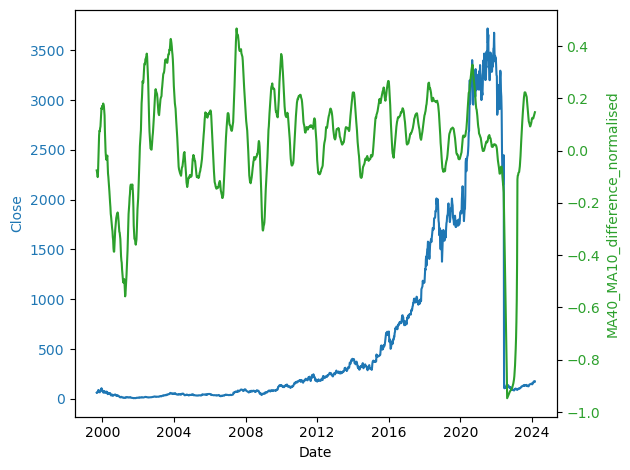

In [25]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot the 'Close' prices on ax1 with the blue color
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close', color=color)
ax1.plot(amzn['Date'], amzn['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot the normalized difference with the green color
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('MA40_MA10_difference_normalised', color=color)
ax2.plot(amzn['Date'], amzn['MA40_MA10_difference_normalised'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
fig.tight_layout()
plt.show()

In [ ]:
amzn['FutureClose'] = amzn['Close'].shift(-1)

# Drop the last row from the DataFrame, as it will have NaN for 'FutureClose'
amzn.dropna(inplace=True)

# Define your feature columns
feature_columns = ['Open', 'High', 'Low', 'Volume', 'MA10', 'MA40', 'RSI', 'MACD', 'Signal_line']

# Now let's prepare the features and target for scaling
features = amzn[feature_columns]
target = amzn['FutureClose']

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1)) # reshape for single feature

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Convert to PyTorch tensors
# If X_train and X_test are already numpy arrays, convert directly without using .values
X_train_tensor = torch.Tensor(X_train)  # Direct conversion from numpy array to tensor
y_train_tensor = torch.Tensor(y_train)

X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Use TensorDataset to wrap tensors
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define model structure
num_features = X_train_tensor.shape[1]  # Number of input features, dynamically determined
num_mfs = 5  # Number of membership functions per feature
num_output = 1  # Assuming a single output

In [ ]:
# Create the ANFIS model
model = make_anfis(X_train_tensor, num_mfs, num_output)

# Define the number of epochs - the number of times the entire dataset will be passed through the network
num_epochs = 50  # You can adjust this based on your specific requirements

# Define log interval for printing out the loss during training
log_interval = 10  # This will print out the loss after every 10 batches

# Optimizer setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function
criterion = torch.nn.MSELoss()  # For regression tasks

# Training loop
for epoch in range(num_epochs):
    model.train()  # Sets the model to training mode (important for things like dropout, batchnorm etc.)
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Clears existing gradients from previous epoch
        output = model(data)  # Pass the data through the model
        loss = criterion(output, target)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Adjust model weights

        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")